## **Feature Engineering and Algorithms testing**
We'll design engineered features and test various machine learning algorithms to see which fits the dataset well.

In [32]:
# Import necessary libraries
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("/home/lyrax/matplotlib-dracula/dracula.mplstyle")
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import datetime

from tqdm import tqdm, trange
import warnings; warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("data/data_clean.csv", parse_dates=['participant_date_of_birth', 'treatment_created_date',
                                                       'claim_finalized_date'])
data.head(3)

,Serial Number,claim_status,provider_type,provider_region,program_cover,participant_date_of_birth,participant_gender,treatment_created_date,claim_finalized_date,item_status,item_name,item_amount,item_quantity,total_item_amount,diagnoses
0,162967.0,Approved,Specialist,NAIROBI,DENTAL,1987-12-19,FEMALE,2021-01-19 10:45:21,2021-01-19 22:38:08,APPROVED,Simple Extraction Permanent,3000.0,1,3000.0,Dental caries
1,162967.0,Approved,Specialist,NAIROBI,DENTAL,1987-12-19,FEMALE,2021-01-19 10:45:21,2021-01-19 22:38:08,APPROVED,Dental Consultation,1500.0,1,1500.0,Dental caries
2,164883.0,Approved,Specialist,NAIROBI,DENTAL,1977-01-01,FEMALE,2021-01-22 10:49:08,2021-01-28 10:48:12,APPROVED,Dental consultation,1500.0,1,1500.0,Dental caries


In [94]:
((pd.to_datetime(datetime.date.today()) - data.participant_date_of_birth).dt.days) / 365

0         34.087912
1         34.087912
2         45.087912
3         45.087912
4         45.087912
            ...    
167167    29.695055
167168    29.695055
167169    29.695055
167170    29.695055
167171    29.695055
Name: participant_date_of_birth, Length: 167172, dtype: float64

In [95]:
# new features from dates
data['participant_age'] = ((pd.to_datetime(datetime.date.today()) - data.participant_date_of_birth).dt.days) / 364


data['participant_yearOB'] = data.participant_date_of_birth.dt.year.astype(int)
data['participant_monthOB'] = data.participant_date_of_birth.dt.month.astype(int)
data['participant_dayOB'] = data.participant_date_of_birth.dt.day.astype(int)

data['treat_cr_year'] = data.treatment_created_date.dt.year.astype(int)
data['treat_cr_month'] = data.treatment_created_date.dt.month.astype(int)
data['treat_cr_day'] = data.treatment_created_date.dt.day.astype(int)
data['treat_cr_weekday'] = pd.Series(data.treatment_created_date.dt.weekday).apply(lambda x: 1 if x<5 else 0).astype(int)

data['claim_final_year'] = data.claim_finalized_date.dt.year.astype(int)
data['claim_final_month'] = data.claim_finalized_date.dt.month.astype(int)
data['claim_final_day'] = data.claim_finalized_date.dt.day.astype(int)
data['claim_final_weekday'] = pd.Series(data.claim_finalized_date.dt.weekday).apply(lambda x: 1 if x<5 else 0).astype(int)

data.sample(3)

,Serial Number,claim_status,provider_type,provider_region,program_cover,participant_date_of_birth,participant_gender,treatment_created_date,claim_finalized_date,item_status,item_name,item_amount,item_quantity,total_item_amount,diagnoses,participant_age,participant_yearOB,participant_monthOB,participant_dayOB,treat_cr_year,treat_cr_month,treat_cr_day,treat_cr_weekday,claim_final_year,claim_final_month,claim_final_day,claim_final_weekday
137672,168117.0,Approved,Hospital,MOMBASA,OUTPATIENT,2004-11-07,FEMALE,2021-01-27 15:17:12,2021-01-28 09:30:38,APPROVED,Efferalgan 1g tablets 8s,58.22,8,465.8,Acute pharyngitis,17.142857,2004,11,7,2021,1,27,1,2021,1,28,1
105036,175260.0,Approved,Hospital,KISUMU,OUTPATIENT,1958-04-14,FEMALE,2021-02-03 08:05:15,2021-02-12 20:39:02,APPROVED,Random Blood Sugar,300.00,1,300.0,Calculus of urinary tract in diseases classifi...,63.870879,1958,4,14,2021,2,3,1,2021,2,12,1
5654,169098.0,Approved,Clinic,KISUMU,OUTPATIENT,1965-02-09,FEMALE,2021-01-29 10:15:54,2021-01-29 11:18:49,APPROVED,TOTAL CORPORATE SHARE,4560.00,1,4560.0,Encounter for administrative examination,57.021978,1965,2,9,2021,1,29,1,2021,1,29,1


In [96]:
# days from treatment creation to claim finalization
data['treat_claim_diff'] = (data.claim_finalized_date - data.treatment_created_date).dt.days

In [97]:
# combination features:
le = LabelEncoder()
le.fit_transform(data.provider_type + data.provider_region)

array([118, 118, 118, ...,  35,  35,  35])

(0.0, 10000.0)

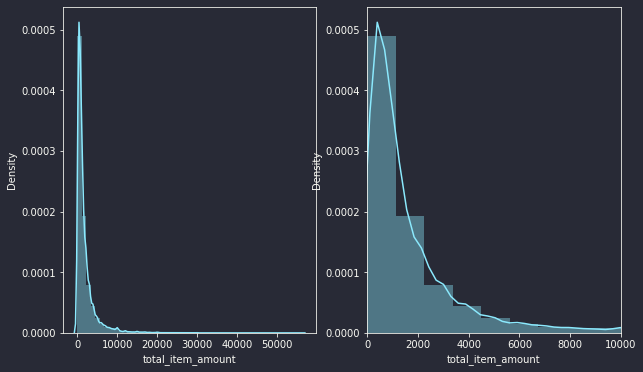

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.distplot(data.total_item_amount, ax=ax[0])
sns.distplot(data.total_item_amount, ax=ax[1])
ax[1].set_xlim([0, 10000])

(0.0, 1000.0)

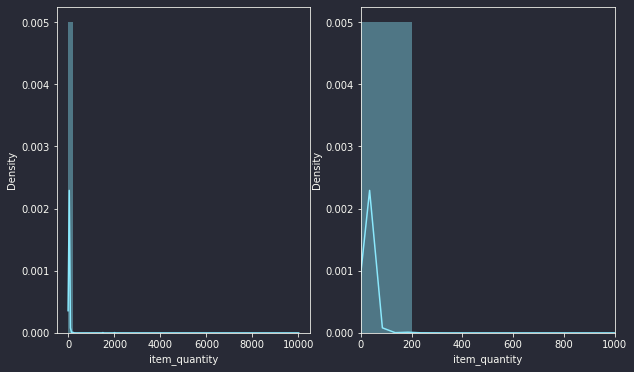

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.distplot(data.item_quantity, ax=ax[0])
sns.distplot(data.item_quantity, ax=ax[1])
ax[1].set_xlim([0, 1000])

<AxesSubplot:xlabel='participant_age', ylabel='Density'>

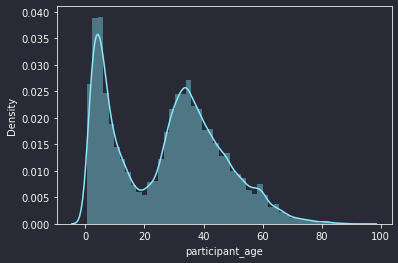

In [126]:
sns.distplot(data.participant_age)

In [127]:
# categorize some continuous variables from information on plots above
data['totals_cat'] = np.select([
    data.total_item_amount <= 1200,
    (data.total_item_amount > 1200) & (data.total_item_amount <= 2300),
    (data.total_item_amount > 2300) & (data.total_item_amount <= 4500),
    (data.total_item_amount > 4500) & (data.total_item_amount <= 10000),
    data.total_item_amount > 10000
], [3, 5, 1, 2, 4])


data['itemq_cat'] = np.select([
    data.item_quantity <= 200,
    data.item_quantity > 200
], [0, 1])


data['age_cat'] = np.select([
    data.participant_age <= 20,
    (data.participant_age > 20) & (data.participant_age <= 40),
    (data.participant_age > 40) & (data.participant_age <= 60),
    data.participant_age > 60
], [3, 0, 2, 1])


data.sample(3)

,Serial Number,claim_status,provider_type,provider_region,program_cover,participant_date_of_birth,participant_gender,treatment_created_date,claim_finalized_date,item_status,item_name,item_amount,item_quantity,total_item_amount,diagnoses,participant_age,participant_yearOB,participant_monthOB,participant_dayOB,treat_cr_year,treat_cr_month,treat_cr_day,treat_cr_weekday,claim_final_year,claim_final_month,claim_final_day,claim_final_weekday,treat_claim_diff,totals_cat,itemq_cat,age_cat
124408,190554.0,Approved,unknown,KAJIADO,OUTPATIENT,1982-05-01,FEMALE,2021-03-03 14:48:13,2021-03-15 18:08:47,APPROVED,URINALYSIS,250.0,1,250.0,Excessive vomiting in pregnancy; Dyspepsia,39.741758,1982,5,1,2021,3,3,1,2021,3,15,1,12,3,0,0
96693,179922.0,Approved,Clinic,MACHAKOS,OUTPATIENT,1988-12-25,FEMALE,2021-02-16 08:38:29,2021-02-18 07:23:11,APPROVED,Panadol advance 500mg Tablets 100s,10.0,20,200.0,"Acute tonsillitis, unspecified",33.065934,1988,12,25,2021,2,16,1,2021,2,18,1,1,3,0,0
134043,193935.0,Not Approved,Clinic,NYERI,OUTPATIENT,1941-01-01,FEMALE,2021-03-09 10:49:51,2021-03-09 10:49:51,SUBMITTED,Thioctic 300mg Tablets 30s,80.0,30,2400.0,Osteoarthritis of knee unspecified,81.211538,1941,1,1,2021,3,9,1,2021,3,9,1,0,1,0,1


We'll encode such columns with fewer unique values to categorical to avoid such large values as > 2000.

Let's see whether we can cluster serial numbers into 2:

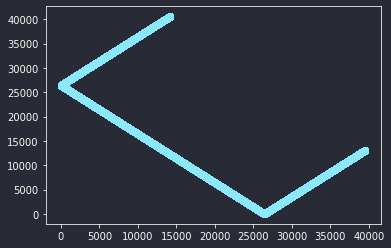

In [146]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
arr = kmeans.fit_transform(np.array(data['Serial Number']).reshape(-1,1))

plt.scatter(arr[:, 0], arr[:, 1])

In [148]:
# serial numbers have a pattern that we can exploit

### **Overall Feature Engineering function**

In [3]:
def feature_engineer(data):
    # label encoder object
    le = LabelEncoder()
    
    # new features from dates
    data['participant_age'] = ((pd.to_datetime(datetime.date.today()) - data.participant_date_of_birth).dt.days) / 364
    
    data['participant_yearOB'] = data.participant_date_of_birth.dt.year.astype(int)
    data['participant_monthOB'] = data.participant_date_of_birth.dt.month.astype(int)
    data['participant_dayOB'] = data.participant_date_of_birth.dt.day.astype(int)
    
    data['treat_cr_year'] = data.treatment_created_date.dt.year.astype(int)
    data['treat_cr_month'] = data.treatment_created_date.dt.month.astype(int)
    data['treat_cr_day'] = data.treatment_created_date.dt.day.astype(int)
    data['treat_cr_weekday'] = pd.Series(data.treatment_created_date.dt.weekday).apply(lambda x: 1 if x<5 else 0).astype(int)
    
    data['claim_final_year'] = data.claim_finalized_date.dt.year.astype(int)
    data['claim_final_month'] = data.claim_finalized_date.dt.month.astype(int)
    data['claim_final_day'] = data.claim_finalized_date.dt.day.astype(int)
    data['claim_final_weekday'] = pd.Series(data.claim_finalized_date.dt.weekday).apply(lambda x: 1 if x<5 else 0).astype(int)
    
    # days from treatment creation to claim finalization
    data['treat_claim_diff'] = (data.claim_finalized_date - data.treatment_created_date).dt.days
    
    # categorize some continuous variables from information on plots above
    data['totals_cat'] = np.select([
        data.total_item_amount <= 1200,
        (data.total_item_amount > 1200) & (data.total_item_amount <= 2300),
        (data.total_item_amount > 2300) & (data.total_item_amount <= 4500),
        (data.total_item_amount > 4500) & (data.total_item_amount <= 10000),
        data.total_item_amount > 10000
    ], [3, 5, 1, 2, 4])
    
    
    data['itemq_cat'] = np.select([
        data.item_quantity <= 200,
        data.item_quantity > 200
    ], [0, 1])
    
    
    data['age_cat'] = np.select([
        data.participant_age <= 20,
        (data.participant_age > 20) & (data.participant_age <= 40),
        (data.participant_age > 40) & (data.participant_age <= 60),
        data.participant_age > 60
    ], [3, 0, 2, 1])
    
    # some combination features
    data['prov_typeXreg'] = le.fit_transform(data.provider_type + data.provider_region)
    data['prov_typeXcover'] = le.fit_transform(data.provider_type + data.program_cover)
    data['prov_regXcover'] = le.fit_transform(data.provider_region + data.program_cover)
    data['prov_typeXgen'] = le.fit_transform(data.provider_type + data.participant_gender)
    data['prov_regXgen'] = le.fit_transform(data.provider_region + data.participant_gender)
    data['coverXgen'] = le.fit_transform(data.program_cover + data.participant_gender)
    data['regXstatus'] = le.fit_transform(data.provider_region + data.item_status)
    data['statusXgen'] = le.fit_transform(data.item_status + data.participant_gender)
    data['coverXstatus'] = le.fit_transform(data.program_cover + data.item_status)
    
    # encoding categorical features
    for col in ['provider_type', 'provider_region', 'program_cover', 'participant_gender', 'item_status', 'item_name']:
        data[col] = le.fit_transform(data[col])
    
    # convert 'continuous' columns with < 5 unique values to categorical
    for col in data.select_dtypes(np.number).columns:
        if data[col].nunique() < 5:
            data[col] = le.fit_transform(data[col])
        else:
            pass
        
    return data

In [4]:
# apply function to data
data = pd.read_csv("data/data_clean.csv", parse_dates=['participant_date_of_birth', 'treatment_created_date',
                                                       'claim_finalized_date'])

data = feature_engineer(data)
display(data.sample(3))
print(data.shape)

,Serial Number,claim_status,provider_type,provider_region,program_cover,participant_date_of_birth,participant_gender,treatment_created_date,claim_finalized_date,item_status,item_name,item_amount,item_quantity,total_item_amount,diagnoses,participant_age,participant_yearOB,participant_monthOB,participant_dayOB,treat_cr_year,treat_cr_month,treat_cr_day,treat_cr_weekday,claim_final_year,claim_final_month,claim_final_day,claim_final_weekday,treat_claim_diff,totals_cat,itemq_cat,age_cat,prov_typeXreg,prov_typeXcover,prov_regXcover,prov_typeXgen,prov_regXgen,coverXgen,regXstatus,statusXgen,coverXstatus
139771,177956.0,Approved,0,31,4,1992-04-20,0,2021-02-12 13:11:18,2021-02-12 17:52:39,0,2199,40.0,10,400.0,Acute upper respiratory infection unspecified,29.739011,1992,4,20,1,2,12,1,1,2,12,1,0,3,0,0,31,4,103,0,61,8,86,0,10
53257,172820.0,Approved,0,37,4,2017-01-16,1,2021-02-03 17:15:07,2021-02-04 14:42:18,0,3616,550.0,1,550.0,Acute tonsillitis; Pneumonia due to other spec...,4.912088,2017,1,16,1,2,3,1,1,2,4,1,0,3,0,3,37,4,115,1,74,9,97,1,10
121785,189812.0,Approved,0,29,4,2015-08-08,1,2021-02-27 13:37:00,2021-03-09 07:54:02,0,9343,1537.0,2,3074.0,Infectious gastroenteritis and colitis unspeci...,6.359890,2015,8,8,1,2,27,0,1,3,9,1,9,1,0,3,29,4,95,1,58,9,80,1,10


(167172, 40)


## **Algorithms testing**

In [35]:
X = data[data.select_dtypes(np.number).columns[1:]]
y = data.claim_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

models = [
    LogisticRegression(),
    SGDClassifier(),
    MultinomialNB(),
    RandomForestClassifier(),
    CatBoostClassifier(verbose=False),
    LGBMClassifier(),
    XGBClassifier()
]

for model in models:
    print(model.__class__.__name__, "\n", "="*40)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(confusion_matrix(y_test, pred), "\n\n", classification_report(y_test, pred), "\nRoc-Auc: ",
         roc_auc_score(y_test.replace({'Approved':1, 'Not Approved':0}), pd.Series(pred).replace({'Approved':1, 'Not Approved':0})))

LogisticRegression 
[[74104  1024]
 [ 3420  5038]] 

               precision    recall  f1-score   support

    Approved       0.96      0.99      0.97     75128
Not Approved       0.83      0.60      0.69      8458

    accuracy                           0.95     83586
   macro avg       0.89      0.79      0.83     83586
weighted avg       0.94      0.95      0.94     83586
 
Roc-Auc:  0.7910095091371954
SGDClassifier 
[[73867  1261]
 [ 6638  1820]] 

               precision    recall  f1-score   support

    Approved       0.92      0.98      0.95     75128
Not Approved       0.59      0.22      0.32      8458

    accuracy                           0.91     83586
   macro avg       0.75      0.60      0.63     83586
weighted avg       0.88      0.91      0.89     83586
 
Roc-Auc:  0.5991981031808024
MultinomialNB 
[[59361 15767]
 [ 4815  3643]] 

               precision    recall  f1-score   support

    Approved       0.92      0.79      0.85     75128
Not Approved       0.19  

Ensemble and boosting algorithms are pretty accurate given that the labels for this dataset are imbalanced.